## Lighthouse Labs
### W09D2 Time Series II

Instructor: Eithar Elbasheer

slides credit: Socorro. 

**Agenda:**

* Introduction to Facebook Prophet

* Time Series as a Supervised Learning problem

* DL for Time Series

## Facebook Prophet

* FB Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.

* It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

### Why use Facebook Prophet?

* It is accurate and fast
    * It is used in many applications across Facebook and it produces reliable forecasts for planning and goal setting.
    * Forescasts in a few seconds.
* Fully automatic
    * No manual effort. Robust to outliers, missing data, changes in time series.
* Tunable forecasts
    * Users can tweak and adjust forecasts. Add your domain knowledge!
* R or Python

### What does Facebook Prophet do?

* Prophet uses a decomposable Time Series Model with three main components: trend, seasonality, and holidays.

$y(t) = g(t) + s(t) + h(t) + e(t)$

$g(t)$ ; trend models non-periodic changes; linear or logistic

$s(t)$ ; seasonality represents periodic changes; i.e. weekly, monthly, yearly

$h(t)$ ; ties in effects of holidays; on potentially irregular schedules ≥ 1 day(s)

$e(t)$ ;  error or changes that are not accommodated by the model.

Prophet fits several linear and non-linear functions of time as components. Prophet’s default settings produce forecasts that are often accurate, with much less effort. If the forecast is not satisfactory — an analyst with no training in time series methods can improve or tweak forecasts using easily-interpretable parameters.

### Demo with Prophet

We are gonig to use the Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University to see some Covid-19 predictions.

What changes in time do you think could affect predictions?

- What about a vaccine? 

In [92]:
# Load packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import requests, json, os, warnings, re

# ignore warnings
import warnings
warnings.simplefilter("ignore", UserWarning)

In [93]:
confirmed_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
recovered_cases_url ="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
death_cases_url ="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

In [94]:
def get_n_melt_data(data_url,case_type):
    df = pd.read_csv(data_url)
    melted_df = df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'])
    melted_df.rename(columns={"variable":"Date","value":case_type},inplace=True)
    return melted_df

def merge_data(confirm_df,recovered_df,deaths_df):
    new_df = confirm_df.join(recovered_df['Recovered']).join(deaths_df['Deaths'])
    return new_df

In [95]:
confirm_df = get_n_melt_data(confirmed_cases_url,"Confirmed")
recovered_df = get_n_melt_data(recovered_cases_url,"Recovered")
deaths_df = get_n_melt_data(death_cases_url,"Deaths")

In [96]:
#confirmed covid cases
confirm_df.head(2)

,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.93911,67.709953,1/22/20,0
1,NaN,Albania,41.15330,20.168300,1/22/20,0


In [8]:
#recovered covid cases
recovered_df.head(2)

,Province/State,Country/Region,Lat,Long,Date,Recovered
0,NaN,Afghanistan,33.93911,67.709953,1/22/20,0
1,NaN,Albania,41.15330,20.168300,1/22/20,0


In [9]:
#Covid related Deaths
deaths_df.head(2)

,Province/State,Country/Region,Lat,Long,Date,Deaths
0,NaN,Afghanistan,33.93911,67.709953,1/22/20,0
1,NaN,Albania,41.15330,20.168300,1/22/20,0


In [97]:
df = merge_data(confirm_df,recovered_df,deaths_df)
df

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Recovered,Deaths
0,NaN,Afghanistan,33.939110,67.709953,1/22/20,0,0.0,0
1,NaN,Albania,41.153300,20.168300,1/22/20,0,0.0,0
2,NaN,Algeria,28.033900,1.659600,1/22/20,0,0.0,0
3,NaN,Andorra,42.506300,1.521800,1/22/20,0,0.0,0
4,NaN,Angola,-11.202700,17.873900,1/22/20,0,0.0,0
...,...,...,...,...,...,...,...,...
297087,NaN,West Bank and Gaza,31.952200,35.233200,11/14/22,703036,NaN,5708
297088,NaN,Winter Olympics 2022,39.904200,116.407400,11/14/22,535,NaN,0
297089,NaN,Yemen,15.552727,48.516388,11/14/22,11945,NaN,2159
297090,NaN,Zambia,-13.133897,27.849332,11/14/22,333685,NaN,4017


In [98]:
df['Date'] = pd.to_datetime(df['Date'])

In [99]:
df.dtypes

Province/State            object
Country/Region            object
Lat                      float64
Long                     float64
Date              datetime64[ns]
Confirmed                  int64
Recovered                float64
Deaths                     int64
dtype: object

After that we will group our data by dates and then **rename** the dates as **ds** and the confirmed cases/recovered cases as **y**. This is the accepted format for feeding data into fbprophet. Hence we have to rename them as such.



In [100]:
global_cases = df.groupby("Date", as_index=False)[['Confirmed','Recovered', 'Deaths']].sum()

In [101]:
global_cases.dtypes

Date         datetime64[ns]
Confirmed             int64
Recovered           float64
Deaths                int64
dtype: object

In [15]:
global_cases

,Date,Confirmed,Recovered,Deaths
0,2020-01-22,557,30.0,17
1,2020-01-23,657,32.0,18
2,2020-01-24,944,39.0,26
3,2020-01-25,1437,88.0,42
4,2020-01-26,2120,67.0,56
...,...,...,...,...
1023,2022-11-10,634260864,0.0,6607751
1024,2022-11-11,634742853,0.0,6609339
1025,2022-11-12,634984320,0.0,6609695
1026,2022-11-13,635167176,0.0,6610132


In [16]:
global_cases.describe()

,Confirmed,Recovered,Deaths
count,1.028000e+03,1.028000e+03,1.028000e+03
mean,2.342419e+08,2.285161e+07,3.544094e+06
std,2.133276e+08,3.816719e+07,2.359251e+06
min,5.570000e+02,-1.000000e+00,1.700000e+01
25%,3.547355e+07,0.000000e+00,1.108878e+06
50%,1.785145e+08,3.599500e+03,3.884935e+06
75%,4.409786e+08,3.379442e+07,6.004748e+06
max,6.355308e+08,1.722783e+08,6.611683e+06


In [102]:
confirmed_cases = global_cases[["Date","Confirmed"]]
recovered_cases = global_cases[["Date","Recovered"]]


In [103]:
confirmed_cases.rename(columns={"Date":"ds","Confirmed":"y"},inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [104]:
confirmed_cases

,ds,y
0,2020-01-22,557
1,2020-01-23,657
2,2020-01-24,944
3,2020-01-25,1437
4,2020-01-26,2120
...,...,...
1023,2022-11-10,634260864
1024,2022-11-11,634742853
1025,2022-11-12,634984320
1026,2022-11-13,635167176


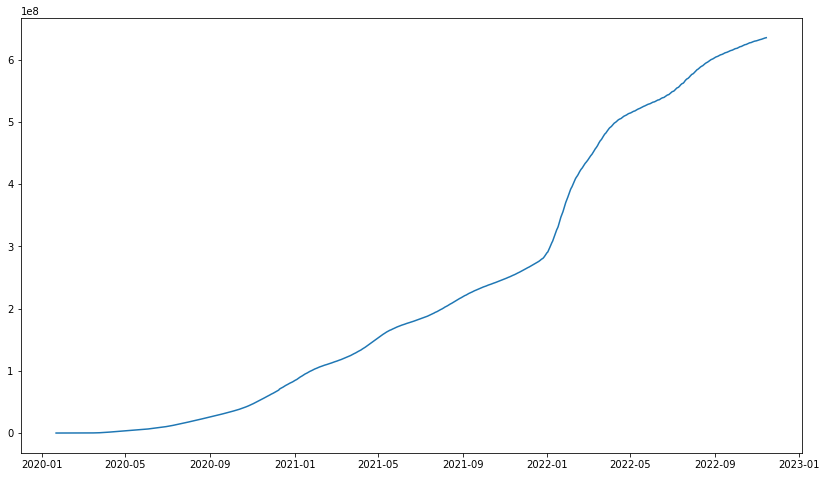

In [20]:
plt.figure(figsize = (14,8))
plt.plot(confirmed_cases['ds'],confirmed_cases['y'])
plt.show()

In [106]:
# train = confirmed_cases[:650] #Before
# test = confirmed_cases[650:] #test, remember this is sequential dataa.

train = confirmed_cases[:710] #Before
test = confirmed_cases[710:] #test, remember this is sequential dataa.

In [107]:
len(confirmed_cases)

1028

In [108]:
test

,ds,y
710,2022-01-01,289995842
711,2022-01-02,290926952
712,2022-01-03,293284330
713,2022-01-04,295798413
714,2022-01-05,298382871
...,...,...
1023,2022-11-10,634260864
1024,2022-11-11,634742853
1025,2022-11-12,634984320
1026,2022-11-13,635167176


In [109]:
train

,ds,y
0,2020-01-22,557
1,2020-01-23,657
2,2020-01-24,944
3,2020-01-25,1437
4,2020-01-26,2120
...,...,...
705,2021-12-27,282031281
706,2021-12-28,283367295
707,2021-12-29,285072588
708,2021-12-30,287022244


Please check out the FB prophet documentation here: https://facebook.github.io/prophet/docs/quick_start.html

In [112]:
# Model Initialize

# !pip install prophet # if you havn't done so
import prophet
from prophet import Prophet

In [113]:
#Check out all the available functions in fb prophet. 
dir(Prophet)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_stan_backend',
 '_logistic_uncertainty',
 '_make_historical_mat_time',
 '_make_trend_shift_matrix',
 '_sample_uncertainty',
 'add_country_holidays',
 'add_group_component',
 'add_regressor',
 'add_seasonality',
 'construct_holiday_dataframe',
 'fit',
 'flat_growth_init',
 'flat_trend',
 'fourier_series',
 'initialize_scales',
 'linear_growth_init',
 'logistic_growth_init',
 'make_all_seasonality_features',
 'make_future_dataframe',
 'make_holiday_features',
 'make_seasonality_features',
 'parse_seasonality_args',
 'percentile',
 'piecewise_linear',
 'piecewise_logistic',
 'plot',
 'plot_components',
 'predict',
 'p

In [114]:
# Initialize Model
m = Prophet(interval_width = 0.95, daily_seasonality= False) #I don't think there is daily seasonality for Covid so we're not sure.

In [115]:
# Fourier order helps with seasonality. 3 for weekly seasonality and 10 for yearly seasonality. You will have to play around
m.add_seasonality(name="monthly",period=30.5,fourier_order=5)

A higher order means we have higher frequency terms and so will be able to fit more quickly-changing and complex seasonality patterns. For yearly patterns, choose 10, for weekly, 3.

In [116]:
# Fit Model
m.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaecr2xmt/16udcb2p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaecr2xmt/gts9bl1e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77813', 'data', 'file=/tmp/tmpaecr2xmt/16udcb2p.json', 'init=/tmp/tmpaecr2xmt/gts9bl1e.json', 'output', 'file=/tmp/tmpaecr2xmt/prophet_modelk4hezidc/prophet_model-20221115183249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [117]:
# Future Date
future_dates = m.make_future_dataframe(periods=30) #predict the future by 30 timesteps
future_dates   #includes the Train Dates + 30 days 

,ds
0,2020-01-22
1,2020-01-23
2,2020-01-24
3,2020-01-25
4,2020-01-26
...,...
735,2022-01-26
736,2022-01-27
737,2022-01-28
738,2022-01-29


In [118]:
# Prediction
prediction =  m.predict(future_dates)

In [119]:
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,-7.137959e+04,-1.562258e+06,1.646908e+06,-7.137959e+04,-7.137959e+04,79684.540349,79684.540349,79684.540349,97678.749492,97678.749492,97678.749492,-17994.209143,-17994.209143,-17994.209143,0.0,0.0,0.0,8.304948e+03
1,2020-01-23,-6.783497e+04,-1.514892e+06,1.540787e+06,-6.783497e+04,-6.783497e+04,152753.497067,152753.497067,152753.497067,102428.210836,102428.210836,102428.210836,50325.286231,50325.286231,50325.286231,0.0,0.0,0.0,8.491853e+04
2,2020-01-24,-6.429035e+04,-1.359620e+06,1.790370e+06,-6.429035e+04,-6.429035e+04,213148.570859,213148.570859,213148.570859,96254.936930,96254.936930,96254.936930,116893.633929,116893.633929,116893.633929,0.0,0.0,0.0,1.488582e+05
3,2020-01-25,-6.074573e+04,-1.436096e+06,1.775995e+06,-6.074573e+04,-6.074573e+04,135895.306789,135895.306789,135895.306789,107213.293897,107213.293897,107213.293897,28682.012892,28682.012892,28682.012892,0.0,0.0,0.0,7.514958e+04
4,2020-01-26,-5.720110e+04,-1.381363e+06,1.654716e+06,-5.720110e+04,-5.720110e+04,112661.965436,112661.965436,112661.965436,152253.172349,152253.172349,152253.172349,-39591.206913,-39591.206913,-39591.206913,0.0,0.0,0.0,5.546086e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,2022-01-26,2.944624e+08,2.901608e+08,2.992978e+08,2.899692e+08,2.991125e+08,89219.084753,89219.084753,89219.084753,107213.293897,107213.293897,107213.293897,-17994.209143,-17994.209143,-17994.209143,0.0,0.0,0.0,2.945516e+08
736,2022-01-27,2.949842e+08,2.902643e+08,3.004885e+08,2.902656e+08,2.998531e+08,202578.458580,202578.458580,202578.458580,152253.172349,152253.172349,152253.172349,50325.286231,50325.286231,50325.286231,0.0,0.0,0.0,2.951868e+08
737,2022-01-28,2.955061e+08,2.905331e+08,3.010276e+08,2.905024e+08,3.005910e+08,330893.481958,330893.481958,330893.481958,213999.848030,213999.848030,213999.848030,116893.633929,116893.633929,116893.633929,0.0,0.0,0.0,2.958370e+08
738,2022-01-29,2.960280e+08,2.909883e+08,3.015040e+08,2.907616e+08,3.013914e+08,275810.519813,275810.519813,275810.519813,247128.506921,247128.506921,247128.506921,28682.012892,28682.012892,28682.012892,0.0,0.0,0.0,2.963038e+08


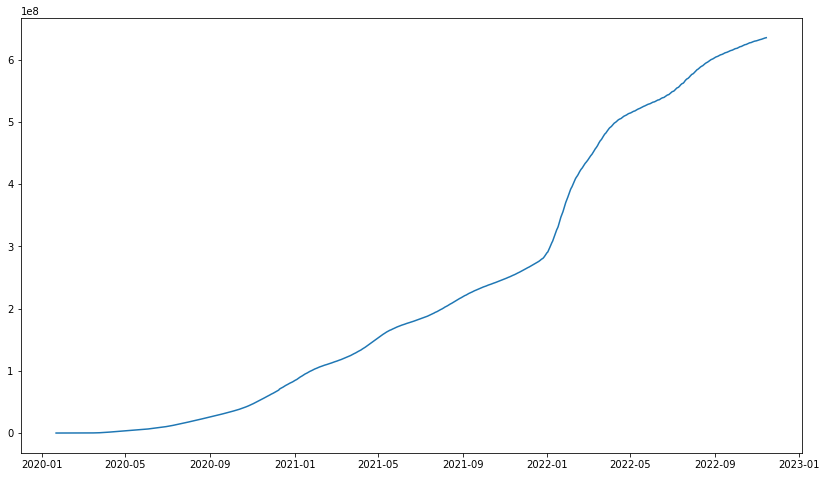

In [120]:
plt.figure(figsize = (14,8))
plt.plot(confirmed_cases['ds'],confirmed_cases['y'])
plt.show()

We can see a few interesting features:
- yhat_lower is lower bound prediction
- yhat_upper is upper bound prediction
- Both are within a 95% confidence interval 
- yhat is the actual prediction

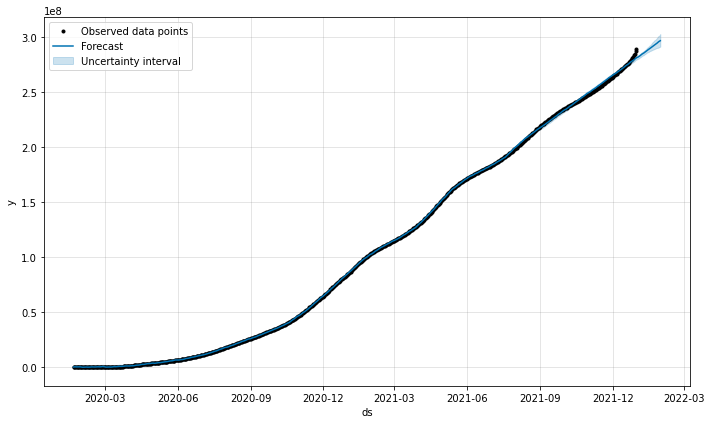

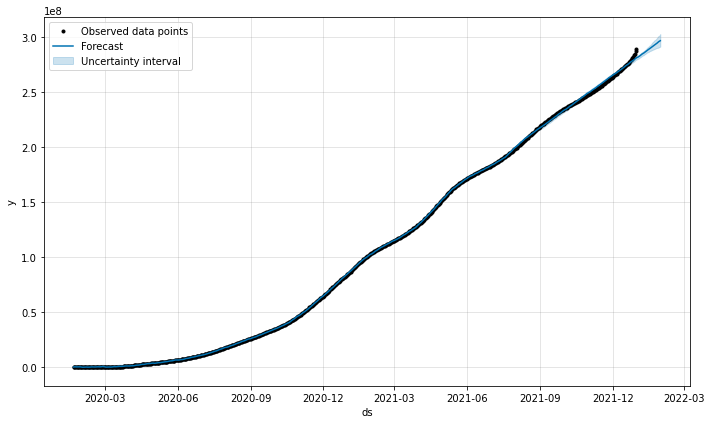

In [121]:
# Plot Prediction
m.plot(prediction, include_legend=True)  #notice the wider confidence intervals the further you go out into the future

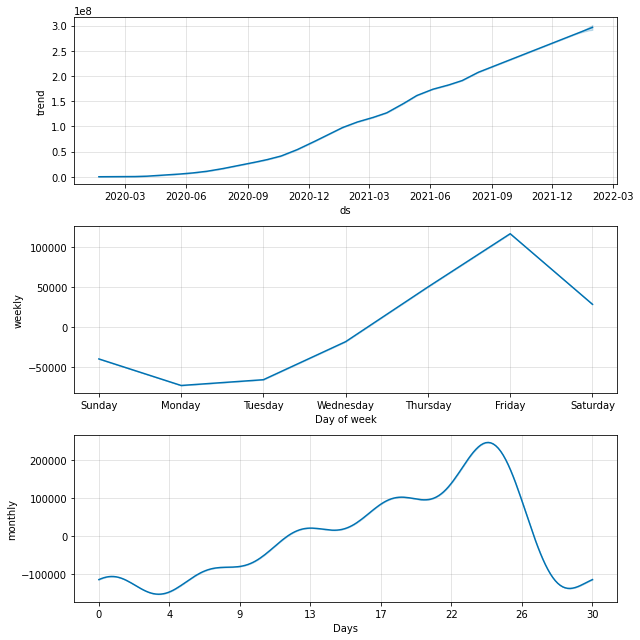

In [51]:
m.plot_components(prediction);

In [122]:
test['dates'] = pd.to_datetime(test['ds'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Real time series frequently have abrupt changes in their trajectories.Prophet tries to detect these changepoints and will allow the trend to adapt appropriately, to see the points that create changes, we can do a changepoints plot.

In [123]:
# Find Point/Dates For Change
from prophet.plot import add_changepoints_to_plot

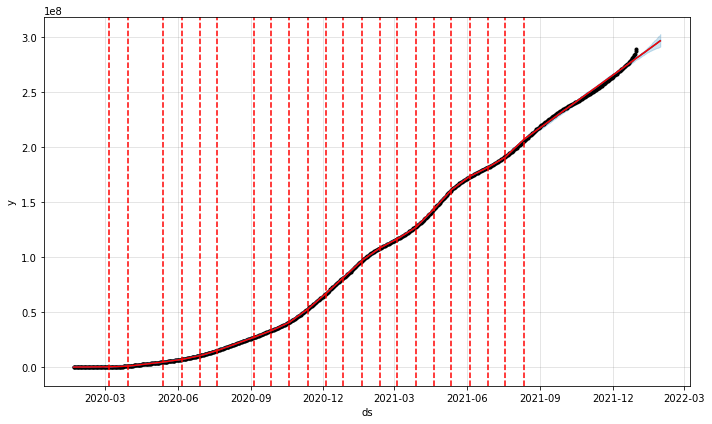

In [124]:
fig = m.plot(prediction)
c = add_changepoints_to_plot(fig.gca(),m,prediction)

## Example 2: Sales Data

Demo from [here](https://github.com/nicknochnack/TimeSeriesForecastingProphet/blob/main/Facebook%20Prophet.ipynb)


In [125]:
df = pd.read_csv("https://raw.githubusercontent.com/nicknochnack/TimeSeriesForecastingProphet/main/dataset.csv")

In [126]:
# Preprocess the data


df['Year'] = df['Time Date'].apply(lambda x: str(x)[-4:])
df['Month'] = df['Time Date'].apply(lambda x: str(x)[-6:-4])
df['Day'] = df['Time Date'].apply(lambda x: str(x)[:-6])
df['ds'] = pd.DatetimeIndex(df['Year']+'-'+df['Month']+'-'+df['Day'])

df = df.loc[(df['Product']==2667437) & (df['Store']=='QLD_CW_ST0203')]
df.drop(['Time Date', 'Product', 'Store', 'Year', 'Month', 'Day'], axis=1, inplace=True)
df.columns = ['y', 'ds']

df.head()

,y,ds
0,2926.000,2018-01-01
1,2687.531,2018-01-02
2,2793.000,2018-01-03
3,2394.000,2018-01-04
4,2660.000,2018-01-05


In [127]:
#Instatiate model
m = Prophet(interval_width=0.95, daily_seasonality=False)
#m.add_seasonality(name="monthly",period=30.5,fourier_order=5)

#Fit
model = m.fit(df)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpaecr2xmt/re1skav4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaecr2xmt/rqmhrsnm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16605', 'data', 'file=/tmp/tmpaecr2xmt/re1skav4.json', 'init=/tmp/tmpaecr2xmt/rqmhrsnm.json', 'output', 'file=/tmp/tmpaecr2xmt/prophet_model7qtifknk/prophet_model-20221115184652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [128]:
#Forcast into the future
future = m.make_future_dataframe(periods=365)

forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,3511.129869,806.080379,4034.226715,3511.129869,3511.129869,-1110.089513,-1110.089513,-1110.089513,16.620837,16.620837,16.620837,-1126.710350,-1126.710350,-1126.710350,0.0,0.0,0.0,2401.040356
1,2018-01-02,3511.886409,764.754477,3879.648888,3511.886409,3511.886409,-1120.275938,-1120.275938,-1120.275938,-11.278868,-11.278868,-11.278868,-1108.997069,-1108.997069,-1108.997069,0.0,0.0,0.0,2391.610472
2,2018-01-03,3512.642950,804.603989,3972.180866,3512.642950,3512.642950,-1094.500063,-1094.500063,-1094.500063,-4.403927,-4.403927,-4.403927,-1090.096136,-1090.096136,-1090.096136,0.0,0.0,0.0,2418.142887
3,2018-01-04,3513.399490,836.202409,4031.954864,3513.399490,3513.399490,-1047.603918,-1047.603918,-1047.603918,22.479532,22.479532,22.479532,-1070.083450,-1070.083450,-1070.083450,0.0,0.0,0.0,2465.795572
4,2018-01-05,3514.156030,914.589086,4006.072143,3514.156030,3514.156030,-1083.664923,-1083.664923,-1083.664923,-34.577231,-34.577231,-34.577231,-1049.087692,-1049.087692,-1049.087692,0.0,0.0,0.0,2430.491107


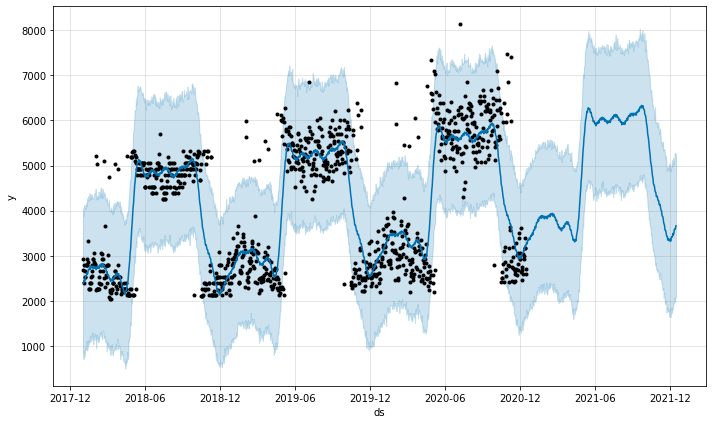

In [59]:
plot1 = m.plot(forecast)

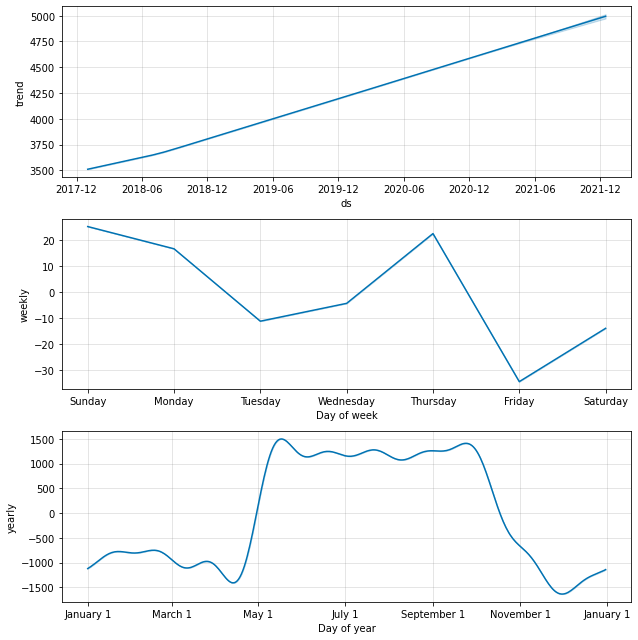

In [60]:
# Decompose your data
plot2 = m.plot_components(forecast)

- The black datapoints are the real observation
- The line is the predicted y-hat

## Time Series Forecasting as Supervised Learning

Review:
* What is Supervised Learning? 
    
* How is data given in SL?

Supervised learning is where you have input variables (X) and an output variable (y) and you use an algorithm to learn the mapping function from the input to the output.

$Y = f(X)$

### Sliding Window For Time Series Data

The reason we can't usually use SL models the same way in TS is because Time Series are not independent variables.

One step usually depends on the previous step.

However, given a sequence of numbers for a Time Series set, the data can be forced to look like a supervised learning problem.

**How?**
We can use previous time steps as input variables and use the next time step as the output variable.

|time  |  measure |
| ---- | -------- |
| 1 | 100 |
| 2 | 110 |
| 3 | 108 |
| 4 | 115 |
| 5 | 120 |

We restructure this dataset as a supervised learning problem like this:
- The X is the day prior's Y is used to predict the y. 
- or
- The X of today is today's Y used to predict the y of tomorrow.

| X    |   y      |
| ---- | -------- |
|? | 100 | 
|100 | 110 | 
|110 |   108 | 
|108 | 115 | 
|115 | 120 | 
|120 | ? | 


**What do you observe?**

* Can't use first value
* Can't use last value
* Do you think the order needs to be preserved? Why or why not?

**Why do we care?**

* We already know how to calculate TS with different statistical models. Why would we use ML?

**Advantages**
* Sometimes TS have a lot of variables. That's when SL comes in useful.

| time| measure1| measure2| 
|----|----|----|
| 1| 0.2| 88| 
| 2| 0.5| 89| 
| 3| 0.7| 87| 
| 4| 0.4| 88| 
| 5| 1.0| 90| 

We will use the previous time step values of measure1 and measure2. 
We also have available the next time step value for measure1. 
We can then predict the next time step value of measure2.



|X1 | X2 | X3 |  y | 
|---|---|---|---|
|? | ? | 0.2  |  88 | 
|0.2 | 88 |  0.5 |  89 | 
|0.5 | 89 |  0.7 |  87 | 
|0.7 | 87 |  0.4 |  88 | 
|0.4 | 88 |  1.0 |  90 | 
|1.0 | 90 |  ? |  ? | 

For multiple output predictions, you can use ANNs, think of predicting more than one value as predicting a sequence. 

In this case, we were predicting two different output variables, but we may want to predict multiple time-steps ahead of one output variable.

In [129]:
from pandas import DataFrame
df = DataFrame()
df['t'] = [x for x in range(10)]
df['t+1']= df['t'].shift(-1)
print(df)

   t  t+1
0  0  1.0
1  1  2.0
2  2  3.0
3  3  4.0
4  4  5.0
5  5  6.0
6  6  7.0
7  7  8.0
8  8  9.0
9  9  NaN


We can see that the forecast column can be taken as an input (X) and the second as an output value (y). That is the input value of 0 can be used to forecast the output value of 1.

Further, the shift function also works on so-called multivariate time series problems. That is where instead of having one set of observations for a time series, we have multiple (e.g. temperature and pressure). All variates in the time series can be shifted forward or backward to create multivariate input and output sequences. We will explore this more later in the tutorial

There are many SL models you can use. For example, linear regression as long as:

* The inclusion of lagged terms as regressors does not create a collinearity problem.
* Both the regressors and the explained variable are stationary
* Your errors are not correlated with each other


Based on tutorial from [here](https://blog.jcharistech.com/2020/03/13/predicting-coronavirus-outbreak-with-facebook-prophets-a-timeseries-forecast/)

### LSTM for Time Series

In [130]:
#Download data from here! https://ca.finance.yahoo.com/
btc_cad = pd.read_csv("/BTC-CAD.csv")

In [131]:
btc_cad.loc[:, "Date"] = pd.to_datetime(btc_cad.Date)

In [132]:
btc_cad = btc_cad.set_index('Date')

In [134]:
btc_cad.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-14,8357.357422,8617.231445,8208.361328,8449.300781,8449.300781,4070880183
2017-11-15,8448.040039,9369.445313,8448.040039,9339.750000,9339.750000,5363263659
2017-11-16,9349.581055,10160.799805,9158.751953,10042.702148,10042.702148,6536956533
2017-11-17,10019.583984,10201.849609,9638.876953,9835.900391,9835.900391,5935065773
2017-11-18,9820.870117,10060.458984,9522.602539,9939.452148,9939.452148,4678967741


In [133]:
train = btc_cad[:1462] #80
test = btc_cad[1462:] #20

In [73]:
assert np.all([train.columns, test.columns])

In [135]:
training_set = train.iloc[:, 1:2].values

In [136]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [76]:
training_set_scaled.shape

(1462, 1)

In [77]:
training_set_scaled

array([[0.05228358],
       [0.06157311],
       [0.07134601],
       ...,
       [0.96413467],
       [0.95207125],
       [0.9606517 ]])

In [137]:
X_train = []
y_train = []

# Training range, from timestep 60 to time step 360, #short, to save computational time. 
for i in range(60, 360):
    X_train.append(training_set_scaled[i-60:i, 0]) #Use the last 60 days to predict stock price
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [138]:
X_train.shape

(300, 60)

In [139]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [140]:
X_train.shape

(300, 60, 1)

In [141]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [142]:
regressor = Sequential()

#return_sequences: Boolean. Whether to return the last output. in the output sequence, or the full sequence. Default: False.
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1)) #Dropout takes 10% of neurons and automatically deactivates it. #Used to prevent overfitting 
                            #and to improve generalization of data

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.1))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 50, batch_size = 52)

Epoch 1/50
6/6 [==============================] - 6s 104ms/step - loss: 0.0023
Epoch 2/50
6/6 [==============================] - 1s 97ms/step - loss: 7.7684e-04
Epoch 3/50
6/6 [==============================] - 1s 102ms/step - loss: 5.5781e-04
Epoch 4/50
6/6 [==============================] - 1s 93ms/step - loss: 4.8907e-04
Epoch 5/50
6/6 [==============================] - 1s 94ms/step - loss: 4.4904e-04
Epoch 6/50
6/6 [==============================] - 1s 99ms/step - loss: 3.5825e-04
Epoch 7/50
6/6 [==============================] - 1s 100ms/step - loss: 3.0187e-04
Epoch 8/50
6/6 [==============================] - 1s 101ms/step - loss: 3.2344e-04
Epoch 9/50
6/6 [==============================] - 1s 96ms/step - loss: 3.0552e-04
Epoch 10/50
6/6 [==============================] - 1s 97ms/step - loss: 2.9525e-04
Epoch 11/50
6/6 [==============================] - 1s 98ms/step - loss: 2.6481e-04
Epoch 12/50
6/6 [==============================] - 1s 99ms/step - loss: 2.5772e-04
Epoch 13/50
6

In [143]:
real_stock_price = test.Open.values
# real_stock_price

In [144]:
# btc_total = pd.concat((btc_cad['Open'], test['Open']), axis=0)

In [145]:
# test_inputs = btc_total[len(btc_total) - len(test) - 60:].values

In [146]:
test_inputs = real_stock_price.reshape(-1,1)
test_inputs = sc.transform(test_inputs)

In [147]:
test_features = []

#Test from time step 60 to time step 200, It will show 140 predicted timesteps 
for i in range(60, 200):
    test_features.append(test_inputs[i-60:i, 0])

In [148]:
X_train.shape

(300, 60, 1)

In [153]:
test_features.shape

(140, 60, 1)

In [149]:
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0],test_features.shape[1], 1))

In [150]:
predictions = regressor.predict(test_features)
# predictions

5/5 [==============================] - 1s 22ms/step


In [151]:
predictions = sc.inverse_transform(predictions)
# predictions

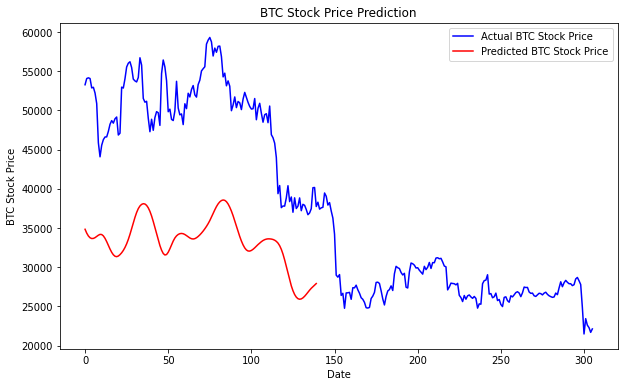

In [152]:
plt.figure(figsize=(10,6))
plt.plot(real_stock_price[60:], color='blue', label='Actual BTC Stock Price')
plt.plot(predictions , color='red', label='Predicted BTC Stock Price')
plt.title('BTC Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('BTC Stock Price')
plt.legend()
plt.show()

Resources
https://research.fb.com/prophet-forecasting-at-scale/